In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

# sign language recognition model

In [ ]:
train_df = pd.read_csv('/content/sign_mnist_train.csv')
test_df = pd.read_csv('/content/sign_mnist_test.csv')

In [ ]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [ ]:
# Show the first lines
train_df.iloc[:4,:10]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,23,134,136,140,145,149,152,155,157,159
1,0,172,174,177,179,180,182,185,186,187
2,19,158,163,167,171,174,176,179,180,182
3,14,172,173,175,176,177,177,178,178,179


In [1]:
print("Number of images in the training set: ",train_df.shape[0])
print("Number of images in the test set: ",test_df.shape[0])

d = int((train_df.shape[1] - 1)**0.5)
print("Shape of the images: ",d ,"x", d)

Number of images in the training set: 27455
Number of images in the test set: 7172
Shape of the images: 28 x 28


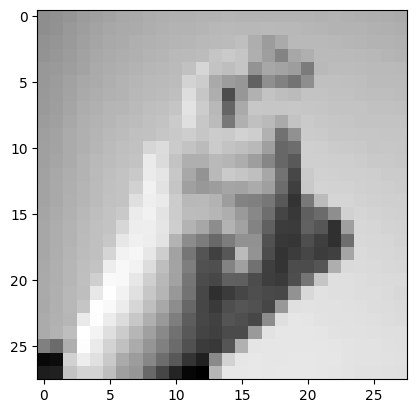

In [ ]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)

# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
# The labels are coded in numbers.
# Create a mapping to get the letters corresponding to the numbers
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

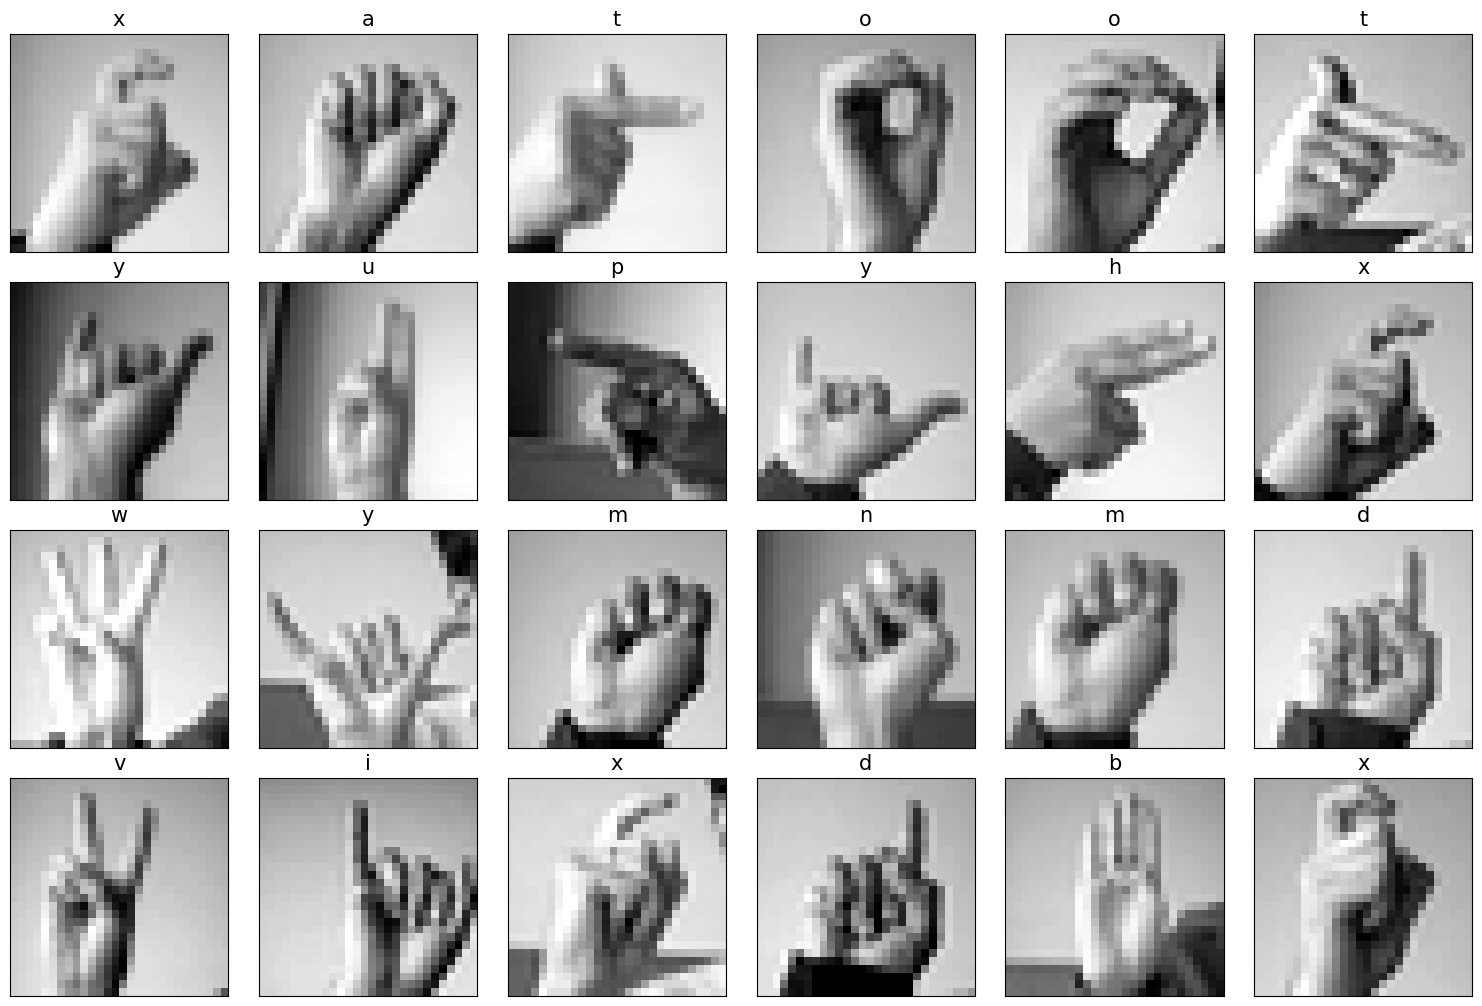

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.Label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

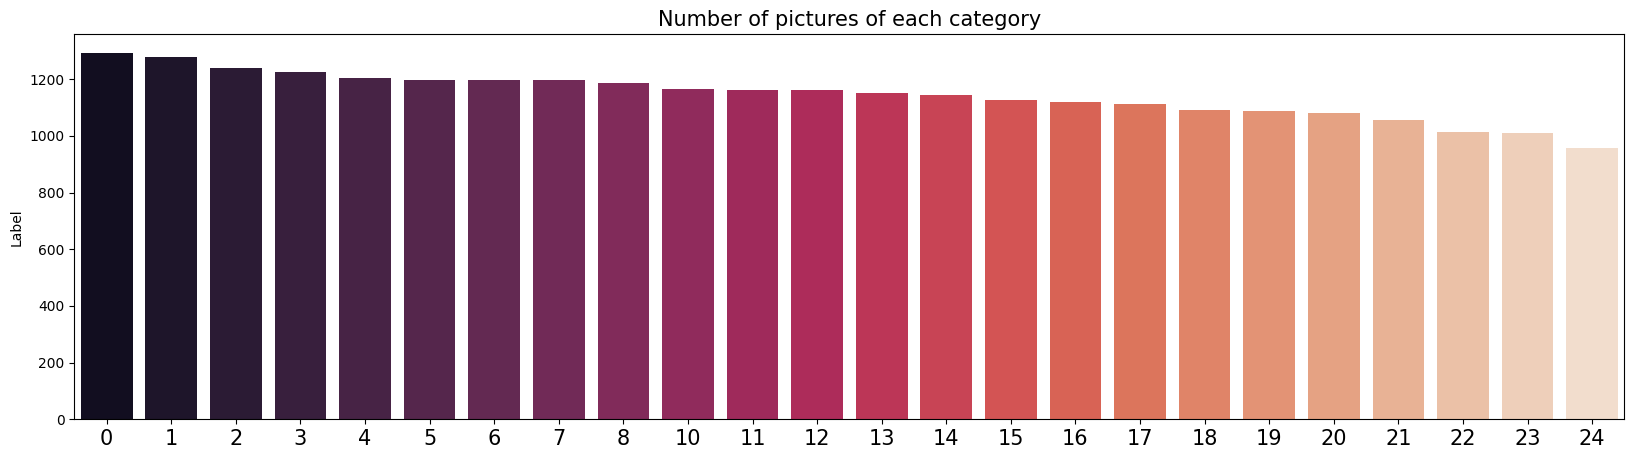

In [ ]:
# Display the number of pictures of each letter
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

In [ ]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [ ]:
# Display the shapes of the sets
X_train.shape, X_val.shape, X_test.shape

((24710, 28, 28, 1), (2745, 28, 28, 1), (7172, 28, 28, 1))

In [ ]:
# Data augmentation
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)
#

In [ ]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),

                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),

                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),

                    Flatten(),

                    Dense(units=1024, activation="relu"),
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         590336    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 512)        0

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow,
                    validation_data=X_val_flow,
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True),

                            learning_rate_reduction
                    ])

Epoch 1/100
773/773 [==============================] - 136s 174ms/step - loss: 1.8320 - accuracy: 0.4103 - val_loss: 0.5224 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 2/100
773/773 [==============================] - 136s 176ms/step - loss: 0.3803 - accuracy: 0.8688 - val_loss: 0.1339 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 3/100
773/773 [==============================] - 131s 170ms/step - loss: 0.1480 - accuracy: 0.9515 - val_loss: 0.0405 - val_accuracy: 0.9891 - lr: 0.0010
Epoch 4/100
773/773 [==============================] - 134s 174ms/step - loss: 0.0869 - accuracy: 0.9732 - val_loss: 0.0536 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 5/100
773/773 [==============================] - 134s 173ms/step - loss: 0.0669 - accuracy: 0.9797 - val_loss: 0.0152 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 6/100
773/773 [==============================] - 133s 172ms/step - loss: 0.0438 - accuracy: 0.9864 - val_loss: 0.0253 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 7/100
773/773 [===================

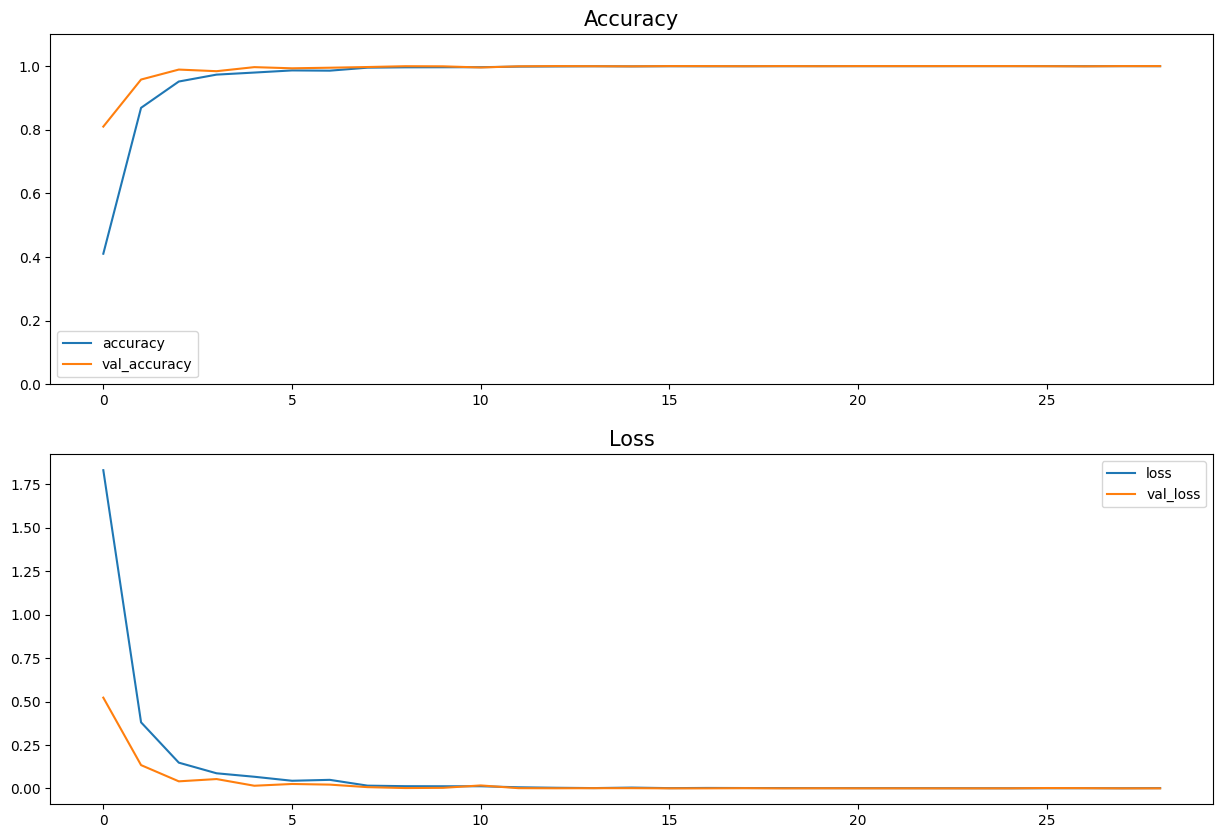

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [3]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

225/225 [==============================] - 6s 28ms/step
99.75% accuracy on the test set


In [ ]:
# Map the numbers into letters
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters = [mapping_letter[x] for x in pred]

In [ ]:
print(classification_report(y_test_letters,pred_letters))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      0.99      1.00       432
           c       1.00      1.00      1.00       310
           d       1.00      1.00      1.00       245
           e       1.00      1.00      1.00       498
           f       0.99      1.00      0.99       247
           g       1.00      1.00      1.00       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       1.00      1.00      1.00       331
           l       1.00      1.00      1.00       209
           m       1.00      1.00      1.00       394
           n       1.00      1.00      1.00       291
           o       1.00      1.00      1.00       246
           p       1.00      0.96      0.98       347
           q       0.92      1.00      0.96       164
           r       0.99      1.00      1.00       144
           s       1.00    

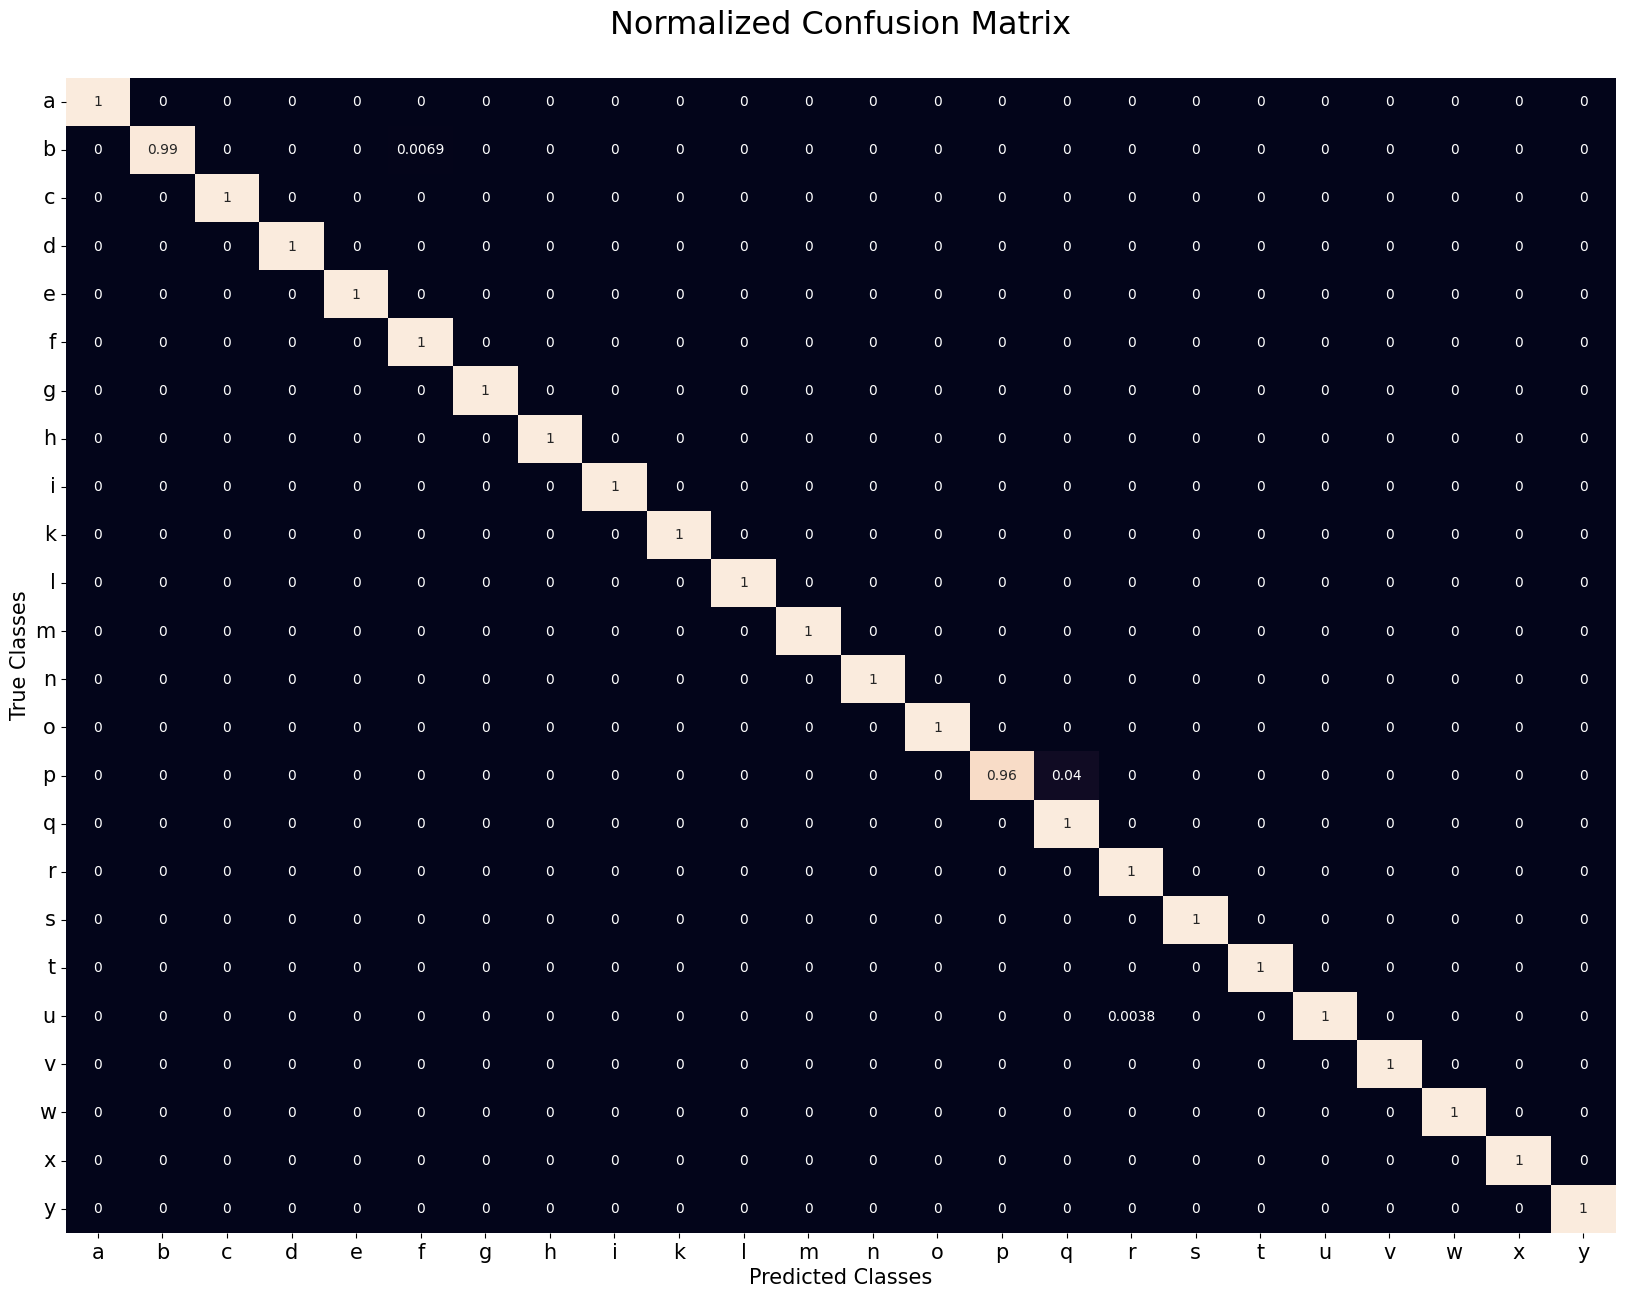

In [ ]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/SignLanguageModel')

# Realtime sign language recognition

In [1]:
import keras
import cv2
import numpy as np
from tensorflow.keras.utils import img_to_array
import imutils
import os

In [2]:
alphabet=['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
model = keras.models.load_model("D:\\SignLanguageModel", compile=False)

In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.10.1'

In [7]:
!pip install --user tensorflow-text

  Using cached tensorflow_text-2.10.0-cp39-cp39-win_amd64.whl (5.0 MB)
  Using cached tensorflow-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
def classify(image):
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    proba=model.predict(image)
    idx = np.argmax(proba)
    return alphabet[idx]

In [25]:
cap = cv2.VideoCapture(0)
while 1:
    ret, img = cap.read()
    image = cv2.imread(r'C:\Users\hp\Pictures\55292500-52acb580-5409-11e9-9a78-7cdc0d8da8b6.png')
    cv2.imshow("image", image)
    img = cv2.flip(img, 1)
    top, right, bottom, left = 75, 350, 300, 590
    #top, right, bottom, left = 75, 200, 300, 200
    roi = img[top:bottom, right:left]
    roi=cv2.flip(roi,1)
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    cv2.imshow('roi',gray)
    alpha=classify(gray)
    cv2.rectangle(img, (left, top), (right, bottom), (0,255,0), 2)
    font=cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,alpha,(0,130),font,5,(0,0,255),2)
    #cv2.resize(img,(1000,1000))
    cv2.imshow('img',img)
    key = cv2.waitKey(1) & 0xFF
    if key==ord('q'):
        break;
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 53ms/step
